In [1]:
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import VotingRegressor
import numpy as np
import pandas as pd
import tensorflow as tf

from imbd.trainers import ModelTrainer
from imbd.data import DataLoader
from imbd.preprocessors import DataPreprocessor
from imbd.models import KerasModel

In [2]:
loader = DataLoader()
prepro = DataPreprocessor()


In [3]:
# initialization
loader = DataLoader()
preprocessor = DataPreprocessor()
df = loader.build()

# get feature & label
train_features = df.drop(loader.labels, axis=1)
train_labels = df[loader.labels]

In [4]:
# base_model = MultiOutputRegressor(XGBRegressor())
base_model = MultiOutputRegressor(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]))

# base_nn_model = KerasRegressor(build_fn=classifier, epochs=100)
base_nn_model = KerasModel()

In [5]:
sample_weight = np.exp(train_labels['Input_A1_020'].values) + 1
param_grid = {
    "prepro__variance_selector__threshold": [0.0, 0.01],
    # "voting__estimator__xgb__subsample": [1, 0.5],
    # "voting__estimator__xgb__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__subsample": [1, 0.5],
    # "voting__estimator__xgb__n_estimators": [1000],
    # "voting__estimator__xgb_rf__n_estimators": [1000],
}

In [6]:
# build pipeline
steps = [('prepro', preprocessor), ('voting', base_model)]
pipe = Pipeline(steps=steps)

In [7]:
pipe.get_params()['voting']

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('xgb',
                                                            XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         gamma=None,
                                                                         gpu_id=None,
                                                                         importance_type='gain',
                                                                         interaction_constraints=None,
                                                                         learning_rate=None,
   

In [8]:
# training
trainer = ModelTrainer(pipe=pipe, param_grid=param_grid, verbose=2)
# fitted = trainer.fit(train_features, train_labels)
fitted = trainer.fit(train_features, train_labels, voting__sample_weight=sample_weight)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] prepro__variance_selector__threshold=0.0 ........................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ......... prepro__variance_selector__threshold=0.0, total=   7.3s
[CV] prepro__variance_selector__threshold=0.0 ........................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[CV] ......... prepro__variance_selector__threshold=0.0, total=   6.8s
[CV] prepro__variance_selector__threshold=0.0 ........................
[CV] ......... prepro__variance_selector__threshold=0.0, total=   7.6s
[CV] prepro__variance_selector__threshold=0.01 .......................
[CV] ........ prepro__variance_selector__threshold=0.01, total=   4.0s
[CV] prepro__variance_selector__threshold=0.01 .......................
[CV] ........ prepro__variance_selector__threshold=0.01, total=   3.7s
[CV] prepro__variance_selector__threshold=0.01 .......................

In [9]:
fitted.best_score_

-0.13695089367340713

In [10]:
pd.DataFrame(fitted.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prepro__variance_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.896054,0.311789,0.322603,0.012890,0,{'prepro__variance_selector__threshold': 0.0},-0.179984,-0.153445,-0.089474,-0.140968,0.037989,2,-0.014571,-0.014305,-0.018259,-0.015712,0.001804
1,3.598419,0.131500,0.292922,0.010655,0.01,{'prepro__variance_selector__threshold': 0.01},-0.143179,-0.151822,-0.115852,-0.136951,0.015331,1,-0.017861,-0.015083,-0.019797,-0.017580,0.001935


In [11]:
pred = fitted.predict(train_features)
pred = pd.DataFrame(pred, columns=train_labels.columns)

res = np.abs(pred - train_labels)
res = res.rename(mapper=lambda x: x + "_diff", axis=1)
res['mean'] = np.mean(res, axis=1)
res['label'] = pd.cut(res['mean'].astype('category'), bins=3, labels=['0', '1', '2'])
res['label'] = res['label'].astype(int)

In [12]:
res

,Input_A6_024_diff,Input_A3_016_diff,Input_C_013_diff,Input_A2_016_diff,Input_A3_017_diff,Input_C_050_diff,Input_A6_001_diff,Input_C_096_diff,Input_A3_018_diff,Input_A6_019_diff,...,Input_A3_015_diff,Input_C_046_diff,Input_C_049_diff,Input_A2_024_diff,Input_C_058_diff,Input_C_057_diff,Input_A3_013_diff,Input_A2_017_diff,mean,label
0,0.000027,0.003489,0.000214,0.000589,1.895428e-07,0.000626,0.000390,0.003528,0.003396,0.003280,...,0.010621,0.000064,0.000078,0.000170,0.001074,0.001390,0.000199,0.002308,0.002485,0
1,0.000072,0.000483,0.000443,0.002927,3.617575e-03,0.000463,0.000001,0.005488,0.001296,0.000312,...,0.005731,0.000171,0.000075,0.000097,0.000835,0.000748,0.000126,0.001040,0.002767,0
2,0.000083,0.001816,0.000203,0.002622,3.338474e-03,0.000780,0.000001,0.001743,0.004055,0.001750,...,0.007164,0.000028,0.000114,0.000017,0.000017,0.001297,0.000376,0.002584,0.002290,0
3,0.000011,0.003464,0.000352,0.003133,3.974398e-03,0.000324,0.000151,0.003216,0.002662,0.002691,...,0.000154,0.000416,0.000310,0.000139,0.000050,0.000103,0.000510,0.000018,0.001429,0
4,0.000147,0.004126,0.000382,0.001996,1.858752e-03,0.000603,0.000401,0.000149,0.004299,0.005045,...,0.003011,0.000052,0.000088,0.000026,0.000673,0.002106,0.001371,0.001912,0.003463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.000239,0.000134,0.000130,0.001865,1.191306e-04,0.000113,0.000001,0.000543,0.002938,0.000199,...,0.006581,0.000106,0.000092,0.000527,0.000012,0.000038,0.000339,0.000321,0.001731,0
335,0.000790,0.004278,0.000139,0.000629,1.779985e-04,0.000136,0.000001,0.000673,0.003193,0.000842,...,0.004480,0.000319,0.000303,0.000281,0.000017,0.000367,0.000350,0.001109,0.002385,0
336,0.000236,0.000288,0.000059,0.000455,3.489761e-03,0.000097,0.000001,0.000651,0.000100,0.001134,...,0.000260,0.000556,0.000026,0.000036,0.000125,0.000471,0.000964,0.002685,0.001629,0
337,0.000074,0.000805,0.000199,0.002603,4.688849e-03,0.000122,0.000001,0.000748,0.002864,0.002812,...,0.003205,0.000077,0.000308,0.000103,0.000027,0.000003,0.000208,0.000274,0.002382,0


In [13]:
import plotly.express as px

In [14]:
res.filter(regex='Input_A[0-9]*_[0-9]+').columns

Index(['Input_A6_024_diff', 'Input_A3_016_diff', 'Input_A2_016_diff',
       'Input_A3_017_diff', 'Input_A6_001_diff', 'Input_A3_018_diff',
       'Input_A6_019_diff', 'Input_A1_020_diff', 'Input_A6_011_diff',
       'Input_A3_015_diff', 'Input_A2_024_diff', 'Input_A3_013_diff',
       'Input_A2_017_diff'],
      dtype='object')

In [15]:
train_labels.columns

Index(['Input_A6_024', 'Input_A3_016', 'Input_C_013', 'Input_A2_016',
       'Input_A3_017', 'Input_C_050', 'Input_A6_001', 'Input_C_096',
       'Input_A3_018', 'Input_A6_019', 'Input_A1_020', 'Input_A6_011',
       'Input_A3_015', 'Input_C_046', 'Input_C_049', 'Input_A2_024',
       'Input_C_058', 'Input_C_057', 'Input_A3_013', 'Input_A2_017'],
      dtype='object')

In [16]:
feature_cols = list(train_features.filter(regex='Input_A[0-9]_020').columns)
diff_cols = list(res.filter(regex='Input_A1_[0-9]+_diff').columns[:5])

fig = px.parallel_coordinates(pd.concat([train_features, res], axis=1), feature_cols + diff_cols + ['label'] , color='label')
fig.update_layout(width=1600, height=800)
fig.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

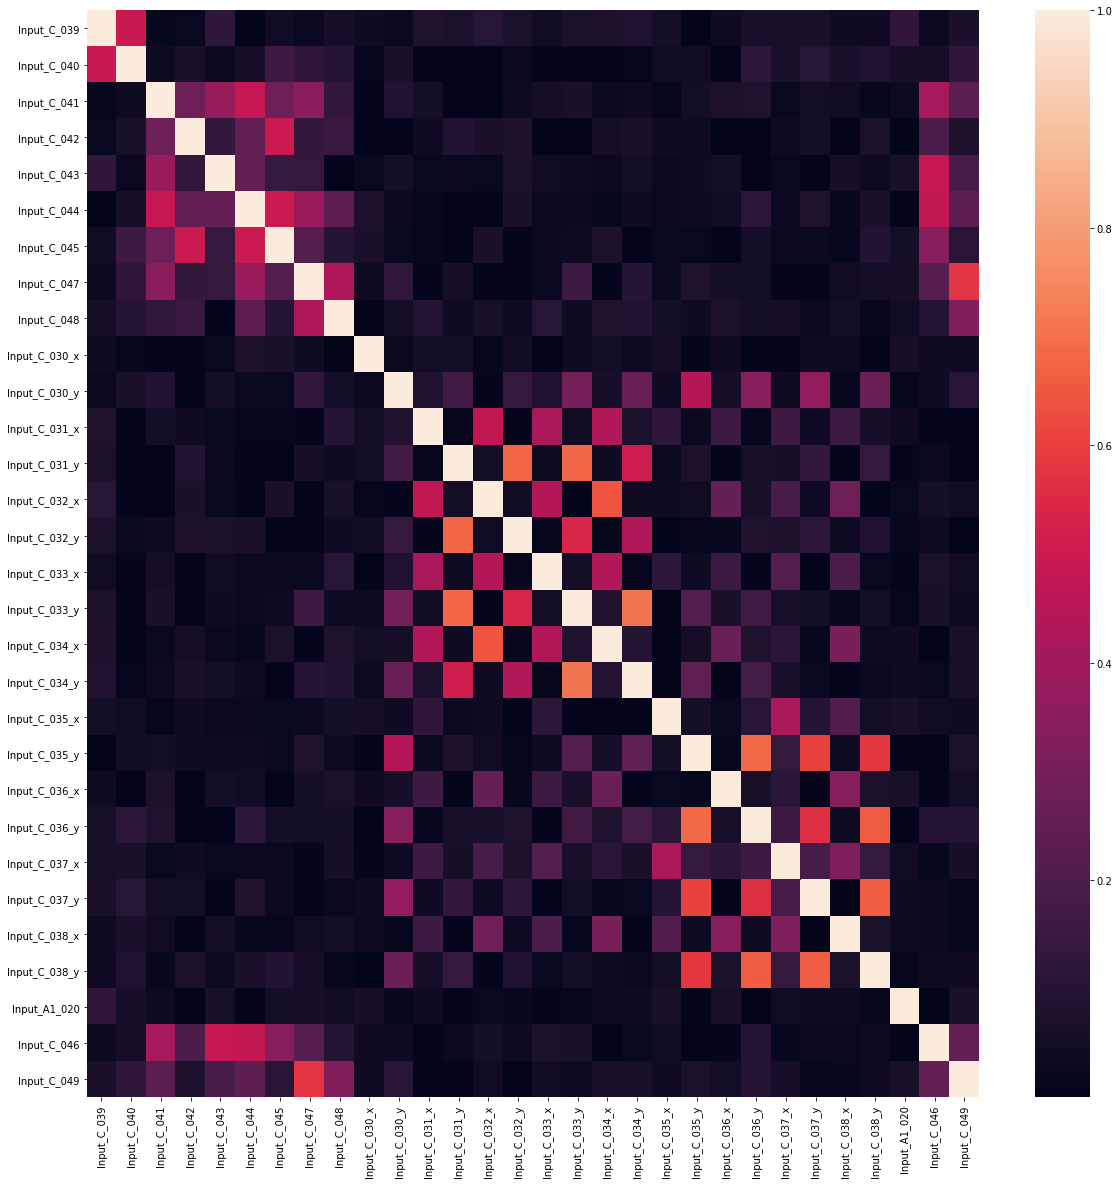

In [18]:
fig_, ax = plt.subplots(figsize=(20, 20))
test = pd.concat([train_features,train_labels], axis=1)
sns.heatmap(np.abs(test.filter(regex='(Input_C_0[3-4][0-9]|Input_A1_020)').corr()))

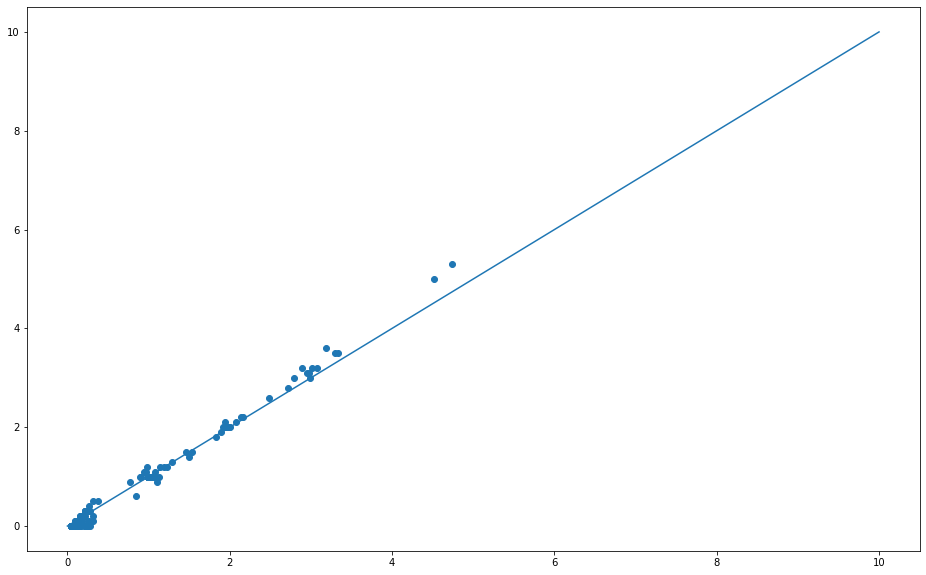

In [19]:
fig, ax = plt.subplots(figsize=(16, 10))
test = pd.concat([pred['Input_A1_020'], train_labels['Input_A1_020']], axis=1)

plt.scatter(test.values[:,0], test.values[:, 1])
x = np.linspace(0, 10, 10)
plt.plot(x, x)


In [20]:
np.sort(test)[-10:]

array([[0.22861823, 0.3       ],
       [0.1       , 0.12259759],
       [0.1       , 0.12068181],
       [0.17158711, 0.2       ],
       [0.1       , 0.12119338],
       [0.1       , 0.11973628],
       [0.1       , 0.12941481],
       [0.1       , 0.12084135],
       [0.1715503 , 0.2       ],
       [0.37171566, 0.5       ]])